In [1]:
%matplotlib inline
import skbio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [2]:
#Using the full American Gut mapping file, we reduced it to only samples that were fecal. 
#The mapping file was then filtered to remove samples which did not have sufficient data 
#(after bloom removal). Following this, host subject IDs representing only a single sample 
#were removed. The time deltas were then generated by iterating over each host subject ID, 
#and computing the time difference in days between all samples associated with that host 
#subject ID.

dm = skbio.DistanceMatrix.read('ag-cleaned-multiple-timepoints_even1250_unweighted.txt')
w_dm = skbio.DistanceMatrix.read('ag-cleaned-multiple-timepoints_even1250_weighted.txt')
deltas = pd.read_csv('ag-cleaned-multiple-timepoints-deltas.txt', sep='\t', dtype=str)

In [3]:
absdeltas = deltas

In [4]:
deltas['DeltaInDays'] = pd.to_numeric(deltas['DeltaInDays'])
absdeltas['DeltaInDays'] = deltas['DeltaInDays'].abs()

In [5]:
unique_ids = pd.unique(deltas['HOST_SUBJECT_ID'])
unique_sampleA = pd.unique(deltas['SampleID-A'])
unique_sampleB = pd.unique(deltas['SampleID-B'])

print(len(unique_ids))
print(len(unique_sampleA))
print(len(unique_sampleB))

565
1553
1553


In [6]:
distance = []
for dl in range(len(absdeltas)):
    distance.append(dm[absdeltas['SampleID-A'][dl], absdeltas['SampleID-B'][dl]])

absdeltas['Distance'] = distance

In [7]:
#What I'm doing here is creating a list delmonths and iterating 
#over absdeltas['DeltasInDays'] to convert the number of days into 
#the closest number of months

delmonths = []
for dl in range(len(absdeltas)):
    if absdeltas['DeltaInDays'][dl]/30 <= 1:
        delmonths.append(1)
    elif absdeltas['DeltaInDays'][dl]/30 <= 2:
        delmonths.append(2)
    elif absdeltas['DeltaInDays'][dl]/30 <= 3:
        delmonths.append(3)
    elif absdeltas['DeltaInDays'][dl]/30 <= 4:
        delmonths.append(4)
    elif absdeltas['DeltaInDays'][dl]/30 <= 5:
        delmonths.append(5)
    elif absdeltas['DeltaInDays'][dl]/30 <= 6:
        delmonths.append(6)
    elif absdeltas['DeltaInDays'][dl]/30 <= 7:
        delmonths.append(7)
    elif absdeltas['DeltaInDays'][dl]/30 <= 8:
        delmonths.append(8)
    elif absdeltas['DeltaInDays'][dl]/30 <= 9:
        delmonths.append(9)
    elif absdeltas['DeltaInDays'][dl]/30 <= 10:
        delmonths.append(10)
    elif absdeltas['DeltaInDays'][dl]/30 <= 11:
        delmonths.append(11)
    elif absdeltas['DeltaInDays'][dl]/30 <= 12:
        delmonths.append(12)
    elif absdeltas['DeltaInDays'][dl]/30 > 12:
        delmonths.append(13)

absdeltas['DeltaInMonths'] = delmonths

In [8]:
uni_sub_del = pd.DataFrame()

In [9]:
#the above loop did not produce the same results as this loop, so
#i am leaving this loop here for the time being.
host_1mo = {}
host_2mo = {}
host_3mo = {}
host_4mo = {}
host_5mo = {}
host_6mo = {}
host_7mo = {}
host_8mo = {}
host_9mo = {}
host_10mo = {}
host_11mo = {}
host_12mo = {}
host_13mo = {}
#these loops are pretty hacky
for dl in range(len(absdeltas)):
    
    if absdeltas['DeltaInMonths'][dl] == 1:
        if (absdeltas['HOST_SUBJECT_ID'][dl] not in host_1mo):
            host_1mo.update({absdeltas['HOST_SUBJECT_ID'][dl]:absdeltas['HOST_SUBJECT_ID'][dl]})
            uni_sub_del = uni_sub_del.append(absdeltas.loc[dl], ignore_index=True)
 
                
    elif absdeltas['DeltaInMonths'][dl] == 2:
        if (absdeltas['HOST_SUBJECT_ID'][dl] not in host_2mo):
            host_2mo.update({absdeltas['HOST_SUBJECT_ID'][dl]:absdeltas['HOST_SUBJECT_ID'][dl]})
            uni_sub_del = uni_sub_del.append(absdeltas.loc[dl], ignore_index=True)
   
                
    elif absdeltas['DeltaInMonths'][dl] == 3:
        if (absdeltas['HOST_SUBJECT_ID'][dl] not in host_3mo):
            host_3mo.update({absdeltas['HOST_SUBJECT_ID'][dl]:absdeltas['HOST_SUBJECT_ID'][dl]})
            uni_sub_del = uni_sub_del.append(absdeltas.loc[dl], ignore_index=True)

            
    elif absdeltas['DeltaInMonths'][dl] == 4:
        if (absdeltas['HOST_SUBJECT_ID'][dl] not in host_4mo):
            host_4mo.update({absdeltas['HOST_SUBJECT_ID'][dl]:absdeltas['HOST_SUBJECT_ID'][dl]})
            uni_sub_del = uni_sub_del.append(absdeltas.loc[dl], ignore_index=True)
            
    elif absdeltas['DeltaInMonths'][dl] == 5:
        if (absdeltas['HOST_SUBJECT_ID'][dl] not in host_5mo):
            host_5mo.update({absdeltas['HOST_SUBJECT_ID'][dl]:absdeltas['HOST_SUBJECT_ID'][dl]})
            uni_sub_del = uni_sub_del.append(absdeltas.loc[dl], ignore_index=True)

            
    elif absdeltas['DeltaInMonths'][dl] == 6:
        if (absdeltas['HOST_SUBJECT_ID'][dl] not in host_6mo):
            host_6mo.update({absdeltas['HOST_SUBJECT_ID'][dl]:absdeltas['HOST_SUBJECT_ID'][dl]})
            uni_sub_del = uni_sub_del.append(absdeltas.loc[dl], ignore_index=True)
    
    elif absdeltas['DeltaInMonths'][dl] == 7:
        if (absdeltas['HOST_SUBJECT_ID'][dl] not in host_7mo):
            host_7mo.update({absdeltas['HOST_SUBJECT_ID'][dl]:absdeltas['HOST_SUBJECT_ID'][dl]})
            uni_sub_del = uni_sub_del.append(absdeltas.loc[dl], ignore_index=True)

    elif absdeltas['DeltaInMonths'][dl] == 8:
        if (absdeltas['HOST_SUBJECT_ID'][dl] not in host_8mo):
            host_8mo.update({absdeltas['HOST_SUBJECT_ID'][dl]:absdeltas['HOST_SUBJECT_ID'][dl]})
            uni_sub_del = uni_sub_del.append(absdeltas.loc[dl], ignore_index=True)
    
    elif absdeltas['DeltaInMonths'][dl] == 9:
        if (absdeltas['HOST_SUBJECT_ID'][dl] not in host_9mo):
            host_9mo.update({absdeltas['HOST_SUBJECT_ID'][dl]:absdeltas['HOST_SUBJECT_ID'][dl]})
            uni_sub_del = uni_sub_del.append(absdeltas.loc[dl], ignore_index=True)
            
    elif absdeltas['DeltaInMonths'][dl] == 10:
        if (absdeltas['HOST_SUBJECT_ID'][dl] not in host_10mo):
            host_10mo.update({absdeltas['HOST_SUBJECT_ID'][dl]:absdeltas['HOST_SUBJECT_ID'][dl]})
            uni_sub_del = uni_sub_del.append(absdeltas.loc[dl], ignore_index=True)
            
    elif absdeltas['DeltaInMonths'][dl] == 11:
        if (absdeltas['HOST_SUBJECT_ID'][dl] not in host_11mo):
            host_11mo.update({absdeltas['HOST_SUBJECT_ID'][dl]:absdeltas['HOST_SUBJECT_ID'][dl]})
            uni_sub_del = uni_sub_del.append(absdeltas.loc[dl], ignore_index=True)
            
    elif absdeltas['DeltaInMonths'][dl] == 12:
        if (absdeltas['HOST_SUBJECT_ID'][dl] not in host_12mo):
            host_12mo.update({absdeltas['HOST_SUBJECT_ID'][dl]:absdeltas['HOST_SUBJECT_ID'][dl]})
            uni_sub_del = uni_sub_del.append(absdeltas.loc[dl], ignore_index=True)
            
    elif absdeltas['DeltaInMonths'][dl] == 13:
        if (absdeltas['HOST_SUBJECT_ID'][dl] not in host_13mo):
            host_13mo.update({absdeltas['HOST_SUBJECT_ID'][dl]:absdeltas['HOST_SUBJECT_ID'][dl]})
            uni_sub_del = uni_sub_del.append(absdeltas.loc[dl], ignore_index=True)

In [10]:
uni_sub_del

,DeltaInDays,DeltaInMonths,Distance,HOST_SUBJECT_ID,SampleID-A,SampleID-B
0,20.0,1.0,0.362365,00c3b34921c822d01470d5c4a03c362171b3b92e013d33...,10317.000012458,10317.000012453
1,113.0,4.0,0.339777,00c3b34921c822d01470d5c4a03c362171b3b92e013d33...,10317.000012458,10317.000012512
2,142.0,5.0,0.337430,00c3b34921c822d01470d5c4a03c362171b3b92e013d33...,10317.000012458,10317.000012514
3,34.0,2.0,0.404055,00c3b34921c822d01470d5c4a03c362171b3b92e013d33...,10317.000012458,10317.000012457
4,78.0,3.0,0.390094,00c3b34921c822d01470d5c4a03c362171b3b92e013d33...,10317.000012512,10317.000012457
5,41.0,2.0,0.399001,01b52077e1664dd9ec3659bda8fc4d1c5242252fcc6fac...,10317.000016448,10317.000016449
6,5.0,1.0,0.391642,020b337a085fdd8c95ab0ff7da0dd4d76cb8659b8a5da8...,10317.000067970,10317.000067971
7,7.0,1.0,0.301272,02889e57a8e65d70db5b545e1334c62e9d319eff755a9f...,10317.000067485,10317.000067486
8,17.0,1.0,0.383832,0291b71283934e54181782e479635c2070546cab6358b1...,10317.000067885,10317.000067887
9,106.0,4.0,0.363100,02c4e9bf266fc340c5aa17da0f34b7860022a0e5df4542...,10317.000042873,10317.000042875


In [11]:
between_dm = dm

In [12]:
for ser in range(len(absdeltas)):
    ind1 = absdeltas['SampleID-A'][ser]
    ind2 = absdeltas['SampleID-B'][ser]
    bind1 = between_dm.index(ind1)
    bind2 = between_dm.index(ind2)
    between_dm[bind1][bind2] = 0

In [13]:
w_between_dm = w_dm
for ser in range(len(absdeltas)):
    ind1 = absdeltas['SampleID-A'][ser]
    ind2 = absdeltas['SampleID-B'][ser]
    bind1 = w_between_dm.index(ind1)
    bind2 = w_between_dm.index(ind2)
    w_between_dm[bind1][bind2] = 0
    
w_between_cform = w_between_dm.condensed_form()
w_zero_indexes = []
for i in range(len(w_between_cform)):
    if w_between_cform[i] == 0:
        w_zero_indexes.append(i)

w_between_arr = np.delete(w_between_cform, w_zero_indexes)

In [14]:
between_cform = between_dm.condensed_form()

In [15]:
zero_indexes = []
for i in range(len(between_cform)):
    if between_cform[i] == 0:
        zero_indexes.append(i)

In [16]:
between_arr = np.delete(between_cform, zero_indexes)

In [17]:
w_dm = skbio.DistanceMatrix.read('ag-cleaned-multiple-timepoints_even1250_weighted.txt')

In [18]:
w_distance = []
for dl in range(len(absdeltas)):
    w_distance.append(w_dm[absdeltas['SampleID-A'][dl], absdeltas['SampleID-B'][dl]])

absdeltas['Weighted Distance'] = w_distance

In [19]:
w_distance = []
for dl in range(len(uni_sub_del)):
    w_distance.append(w_dm[uni_sub_del['SampleID-A'][dl], uni_sub_del['SampleID-B'][dl]])

uni_sub_del['Weighted Distance'] = w_distance

In [20]:
#create the column for unweighted between sample distances, labeled BSD
bet_delmonths = []
for i in range(len(between_arr)):
    bet_delmonths.append(14)

In [21]:
#create the column for weighted between sample distances, labeled BSD
w_bet_delmonths = []
for i in range(len(w_between_arr)):
    w_bet_delmonths.append(14)

In [22]:
bet_cols = ['Distance']
between_df = pd.DataFrame(data=between_arr, columns=bet_cols)

In [23]:
between_df["DeltaInMonths"] = bet_delmonths

In [24]:
w_bet_cols = ['Weighted Distance']

w_between_df = pd.DataFrame(data=w_between_arr, columns=w_bet_cols)
w_between_df["DeltaInMonths"] = w_bet_delmonths
tot_between_df = pd.concat([between_df, w_between_df], ignore_index=True)

In [25]:
with_betweens_absdeltas = absdeltas.append(tot_between_df, ignore_index=True)

# RESULTS 
Here are the boxplots with the unweighted distances including the between sample distances as month 14, and below those are the boxplots of the weighted samples. As expected, the median for the between sample distances in notably higher than within sample distances. 

## Unweighted Distances for all within sample distances

In [26]:
#BSD denotes between sample distances
with_betweens_absdeltas['DeltaInMonths'] = pd.to_numeric(with_betweens_absdeltas['DeltaInMonths'], downcast='integer')
with_betweens_absdeltas.loc[with_betweens_absdeltas.DeltaInMonths == 14, 'DeltaInMonths'] = 'BSD'

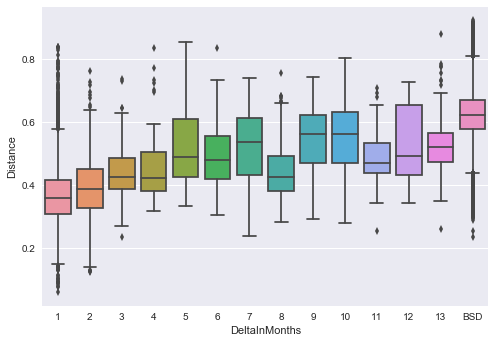

In [27]:
boxorder = [1,2,3,4,5,6,7,8,9,10,11,12,13,'BSD']
seaborn.boxplot(x="DeltaInMonths", y="Distance", data=with_betweens_absdeltas, order=boxorder)

In [28]:
with_betweens_unisubs = uni_sub_del.append(tot_between_df, ignore_index=True)

## Unweighted Distances for only unique subject distances in each month

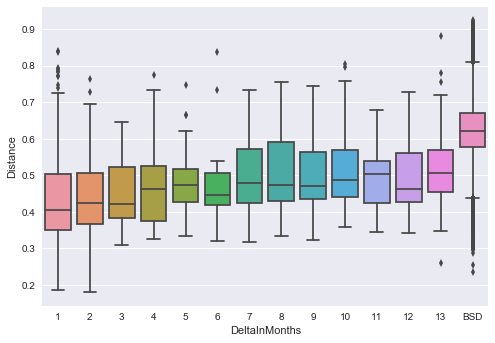

In [29]:
#BSD denotes between sample distances
boxorder = [1,2,3,4,5,6,7,8,9,10,11,12,13,'BSD']
with_betweens_unisubs['DeltaInMonths'] = pd.to_numeric(with_betweens_unisubs['DeltaInMonths'], downcast='integer')
with_betweens_unisubs.loc[with_betweens_unisubs.DeltaInMonths == 14, 'DeltaInMonths'] = 'BSD'
seaborn.boxplot(x="DeltaInMonths", y="Distance", data=with_betweens_unisubs, order=boxorder)

## Weighted Distances for all within sample distances

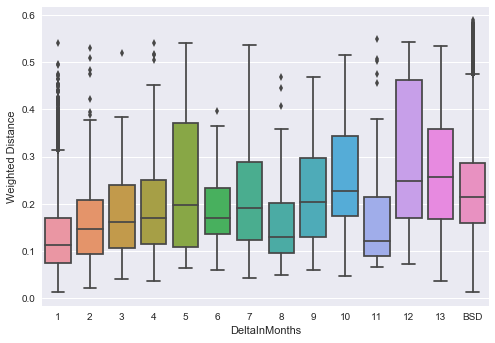

In [30]:
seaborn.boxplot(x="DeltaInMonths", y="Weighted Distance", data=with_betweens_absdeltas, order=boxorder)

## Weighted Distances for only unique subject distances in each month

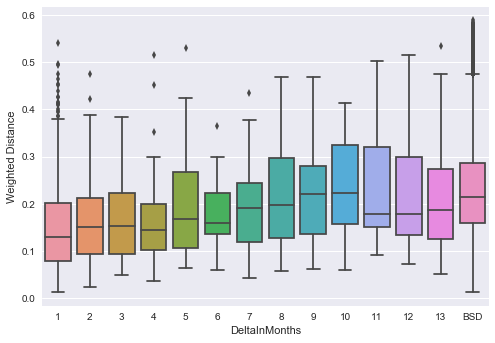

In [31]:
seaborn.boxplot(x="DeltaInMonths", y="Weighted Distance", data=with_betweens_unisubs, order=boxorder)

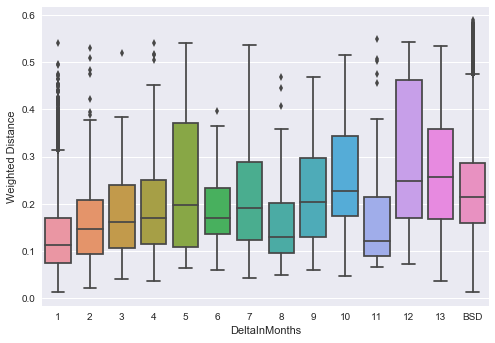

In [32]:
seaborn.boxplot(x="DeltaInMonths", y="Weighted Distance", data=with_betweens_absdeltas, order=boxorder)

In [33]:
with_betweens_unisubs['DeltaInMonths'].value_counts()

BSD    4467970
1          406
2           81
13          79
3           40
4           36
5           32
7           23
9           22
8           22
10          21
6           19
12          18
11          14
Name: DeltaInMonths, dtype: int64

In [34]:
with_betweens_absdeltas["DeltaInMonths"].value_counts()

BSD    4467970
1         6036
2          568
13         517
3          173
8          114
4           96
10          82
7           81
9           70
5           52
6           48
11          45
12          36
Name: DeltaInMonths, dtype: int64

In [35]:
counts = with_betweens_unisubs['DeltaInMonths'].value_counts()

In [36]:
counts

BSD    4467970
1          406
2           81
13          79
3           40
4           36
5           32
7           23
9           22
8           22
10          21
6           19
12          18
11          14
Name: DeltaInMonths, dtype: int64

In [37]:
counts.sum() - counts['BSD']

813

In [38]:
del_in_month_counts = []
for i in range(counts.sum() - counts['BSD']):
    j = with_betweens_unisubs['DeltaInMonths'][i]
    dimc = str(with_betweens_unisubs['DeltaInMonths'][i]) + '(' + str(counts[j]) + ')'
    del_in_month_counts.append(dimc)

In [39]:
bsds = with_betweens_unisubs['DeltaInMonths'][(counts.sum()-counts['BSD']):counts.sum()]

In [40]:
#del_in_month_counts.append(bsds.values)

In [41]:
del_in_month_countsnp = np.array(del_in_month_counts)

In [42]:
bsds

813        BSD
814        BSD
815        BSD
816        BSD
817        BSD
818        BSD
819        BSD
820        BSD
821        BSD
822        BSD
823        BSD
824        BSD
825        BSD
826        BSD
827        BSD
828        BSD
829        BSD
830        BSD
831        BSD
832        BSD
833        BSD
834        BSD
835        BSD
836        BSD
837        BSD
838        BSD
839        BSD
840        BSD
841        BSD
842        BSD
          ... 
4468753    BSD
4468754    BSD
4468755    BSD
4468756    BSD
4468757    BSD
4468758    BSD
4468759    BSD
4468760    BSD
4468761    BSD
4468762    BSD
4468763    BSD
4468764    BSD
4468765    BSD
4468766    BSD
4468767    BSD
4468768    BSD
4468769    BSD
4468770    BSD
4468771    BSD
4468772    BSD
4468773    BSD
4468774    BSD
4468775    BSD
4468776    BSD
4468777    BSD
4468778    BSD
4468779    BSD
4468780    BSD
4468781    BSD
4468782    BSD
Name: DeltaInMonths, Length: 4467970, dtype: object

In [43]:
#np.insert(bsds.values, 0, del_in_month_countsnp)

In [45]:
trimonths = []
for i in range(counts.sum() - counts['BSD']):
    if with_betweens_unisubs['DeltaInMonths'][i] in range(1, 4):
        trimonths.append('1-3')
    elif with_betweens_unisubs['DeltaInMonths'][i] in range(4, 7):
        trimonths.append('4-6')
    elif with_betweens_unisubs['DeltaInMonths'][i] in range(7, 10):
        trimonths.append('7-9')
    elif with_betweens_unisubs['DeltaInMonths'][i] in range(10, 13):
        trimonths.append('10-12')
    elif with_betweens_unisubs['DeltaInMonths'][i] == 13:
        trimonths.append('>12')
    elif with_betweens_unisubs['DeltaInMonths'][i] == 14:
        trimonths.append('BSD')


In [46]:
for i in range(counts['BSD']):
    trimonths.append('BSD')

In [47]:
with_betweens_unisubs['DeltaInMonths(by three)'] = trimonths

# Unique subject unweighted within sample distances by 3 months 

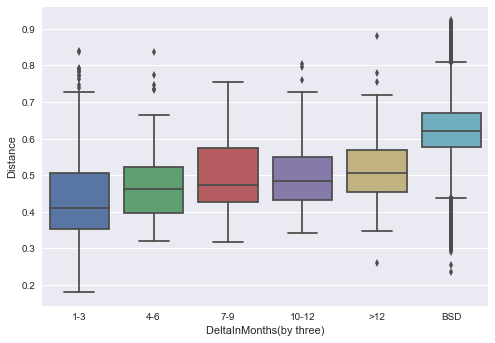

In [48]:
boxorder=['1-3', '4-6', '7-9', '10-12', '>12', 'BSD']
seaborn.boxplot(x='DeltaInMonths(by three)', y='Distance', data=with_betweens_unisubs, order=boxorder)